# Community Deception

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Pytorch Geometric

If we are on Kaggle we need to run the following cells to install Pytorch Geometric

In [2]:
import torch
import os

print(torch.__version__)
os.environ["TORCH"] = torch.__version__

print(torch.version.cuda)
os.environ["CUDA"] = "cu118"

2.0.1+cu118
11.8


In [3]:
! pip install torch_geometric
# ! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
! pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=d0991f2b39d0cc006e223a998af9ec1c589570a3a6813c4f59b46ff6acfa0c02
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 60.1 MB/s eta 0:00:00
     ━━━

**IMPORTANT!!!**
After the libraries installation, restart the runtime and start executing the cells below

## Import Libraries

In [8]:
# Import torch and os another time to reset the colab enviroment after PyG installation
import torch
import os

# Typing
from typing import List, Tuple, Set
from collections import Counter, namedtuple

# Deep Learning
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch.distributions import MultivariateNormal

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy

# Graph
import networkx as nx
import igraph as ig

# Misc
from enum import Enum
from tqdm import trange
import math
import random
import json

# Plot
import matplotlib.pyplot as plt
plt.style.use('default')


## Utils

In [9]:
class FilePaths(Enum):
    """Class to store file paths for data and models"""
    # ° Local
    # DATASETS_DIR = 'dataset/data'
    # LOG_DIR    = 'src/logs/'
    # TEST_DIR = 'test/'
    # ° Kaggle
    # DATASETS_DIR = '/kaggle/input/network-community'
    # LOG_DIR    = 'logs/'
    # ° Google Colab
    DATASETS_DIR = "/content/drive/MyDrive/Sapienza/Tesi/Datasets"
    LOG_DIR = "/content/drive/MyDrive/Sapienza/Tesi/Logs/"
    TEST_DIR = "/content/drive/MyDrive/Sapienza/Tesi/Test/"

    # Dataset file paths
    KAR = DATASETS_DIR + '/kar.mtx'
    DOL = DATASETS_DIR + '/dol.mtx'
    MAD = DATASETS_DIR + '/mad.mtx'
    LESM = DATASETS_DIR + '/lesm.mtx'
    POLB = DATASETS_DIR + '/polb.mtx'
    WORDS = DATASETS_DIR + '/words.mtx'
    ERDOS = DATASETS_DIR + '/erdos.mtx'
    POW = DATASETS_DIR + '/pow.mtx'
    FB_75 = DATASETS_DIR + '/fb-75.mtx'
    DBLP = DATASETS_DIR + '/dblp.mtx'
    ASTR = DATASETS_DIR + '/astr.mtx'
    AMZ = DATASETS_DIR + '/amz.mtx'
    YOU = DATASETS_DIR + '/you.mtx'
    ORK = DATASETS_DIR + '/ork.mtx'


class HyperParams(Enum):
    """ Hyperparameters for the model."""

    """ Graph Encoder Parameters """""
    G_IN_SIZE = 64
    G_HIDDEN_SIZE_1 = 128
    G_HIDDEN_SIZE_2 = 64
    G_EMBEDDING_SIZE = 32

    """ Agent Parameters"""
    HIDDEN_SIZE_1 = 64
    HIDDEN_SIZE_2 = 128
    ACTION_STD = 0.5
    EPS_CLIP = 0.2
    LR = 1e-3
    GAMMA = 0.99

    """ Training Parameters """
    # Number of episodes to collect experience
    MAX_EPISODES = 1000 # 200 # 15000
    # Maximum number of time steps per episode
    MAX_TIMESTEPS = 10  # ! Unused, I set it to the double of the edge budget
    # Update the policy after N timesteps
    UPDATE_TIMESTEP = 100  # ! Unused, I set it to 10 times the edge budget
    # Update policy for K epochs
    K_EPOCHS = 20
    # Print info about the model after N episodes
    LOG_INTERVAL = 20
    # Exit if the average reward is greater than this value
    SOLVED_REWARD = 0.7
    # Save model after N episodes
    SAVE_MODEL = int(MAX_EPISODES / 10)
    # Use a random seed
    RANDOM_SEED = 42

    """Hyperparameters for the Environment"""
    BETA = 10  # Numeber of possible action with BETA=30, is 30% of the edges
    DEBUG = False
    # Weight to balance the reward between NMI and Deception Score
    WEIGHT = 0.7


class DetectionAlgorithms(Enum):
    """
    Enum class for the detection algorithms
    """
    LOUV = "louvain"
    WALK = "walktrap"
    GRE = "greedy"
    INF = "infomap"
    LAB = "label_propagation"
    EIG = "eigenvector"
    BTW = "edge_betweenness"
    SPIN = "spinglass"
    OPT = "optimal"
    SCD = "scalable_community_detection"


class Utils:
    """Class to store utility functions"""

    @staticmethod
    def get_device_placement():
        """Get device placement, CPU or GPU"""
        return os.getenv("RELNET_DEVICE_PLACEMENT", "CPU")

    @staticmethod
    def import_mtx_graph(file_path: str) -> nx.Graph:
        """
        Import a graph from a .mtx file

        Parameters
        ----------
        file_path : str
            File path of the .mtx file

        Returns
        -------
        nx.Graph
            Graph imported from the .mtx file
        """
        try:
            graph_matrix = scipy.io.mmread(file_path)
            graph = nx.Graph(graph_matrix)
            for node in graph.nodes:
                # graph.nodes[node]['name'] = node
                graph.nodes[node]['num_neighbors'] = len(
                    list(graph.neighbors(node)))
            return graph
        except Exception as exception:
            print("Error: ", exception)
            return None

    @staticmethod
    def generate_lfr_benchmark_graph(
        n: int=10000,
        tau1: float=3,
        tau2: float=1.5,
        mu: float=0.1,              # TODO: Test also 0.3 and 0.6
        average_degree: float=5,
        min_community: int=20,
        seed: int=10)->Tuple[nx.Graph, str]:
        """
        Generate a LFR benchmark graph for community detection algorithms.

        Parameters
        ----------
        n : int, optional
            _description_, by default 250
        tau1 : float, optional
            _description_, by default 3
        tau2 : float, optional
            _description_, by default 1.5
        mu : float, optional
            _description_, by default 0.1
        average_degree : float, optional
            _description_, by default 5
        min_community : int, optional
            _description_, by default 20
        seed : int, optional
            _description_, by default 10

        Returns
        -------
        nx.Graph
            Synthetic graph generated with the LFR benchmark
        file_path : str
            Path to the file where the graph is saved
        """
        graph = nx.generators.community.LFR_benchmark_graph(
            n=n,
            tau1=tau1,
            tau2=tau2,
            mu=mu,
            average_degree=average_degree,
            min_community=min_community,
            seed=seed)
        file_path = FilePaths.DATASETS_DIR.value + f"/lfr_benchmark_mu-{mu}.mtx"
        nx.write_edgelist(graph, file_path, data=False)
        return graph, file_path

    @staticmethod
    def check_dir(path: str):
        """
        Check if the directory exists, if not create it.

        Parameters
        ----------
        path : str
            Path to the directory
        """
        if not os.path.exists(path):
            os.makedirs(path)


    @staticmethod
    def plot_training(
        log: dict,
        env_name: str,
        detection_algorithm: str,
        file_path: str):
        """Plot the training results

        Parameters
        ----------
        log : dict
            Dictionary containing the training logs
        env_name : str
            Name of the environment
        detection_algorithm : str
            Name of the detection algorithm
        file_path : str
            Path to save the plot
        """
        # Plot the average reward and the time steps of the episodes in the same
        # plot, using matplotlib, where the average reward is the blue line and
        # the episode length are the orange line.
        _, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Average Reward', color=color)
        # ° Plot Lines
        ax1.plot(log["train_avg_reward"], color=color)
        # ° Plot Points
        # ax1.scatter(range(len(log["train_avg_reward"])), log["train_avg_reward"], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:orange'
        ax2.set_ylabel('Time Steps', color=color)
        # ° Plot Lines
        ax2.plot(log["train_steps"], color=color)
        # ° Plot Points
        # ax2.scatter(range(len(log["train_steps"])), log["train_steps"], color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f"Training on {env_name} graph with {detection_algorithm} algorithm")
        plt.savefig(
            f"{file_path}/{env_name}_{detection_algorithm}_training_reward.png")
        plt.show()

        # Plot the Actor and Critic loss in the same plot, using matplotlib
        # with the Actor loss in green and the Critic loss in red.
        _, ax1 = plt.subplots()
        color = 'tab:green'
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Actor Loss', color=color)
        # ° Plot Lines
        ax1.plot(log["a_loss"], color=color)
        # ° Plot Points
        # ax1.scatter(range(len(log["a_loss"])), log["a_loss"], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Critic Loss', color=color)
        # ° Plot Lines
        ax2.plot(log["v_loss"], color=color)
        # ° Plot Points
        # ax2.scatter(range(len(log["v_loss"])), log["v_loss"], color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f"Training on {env_name} graph with {detection_algorithm} algorithm")
        plt.savefig(
            f"{file_path}/{env_name}_{detection_algorithm}_training_loss.png")
        plt.show()

    @staticmethod
    def save_training(
            log: dict,
            env_name: str,
            detection_algorithm: str,
            file_path: str):
        """Plot the training results

        Parameters
        ----------
        log : dict
            Dictionary containing the training logs
        env_name : str
            Name of the environment
        detection_algorithm : str
            Name of the detection algorithm
        file_path : str
            Path to save the plot
        """
        file_name = f"{file_path}/{env_name}_{detection_algorithm}_results.json"
        with open(file_name, "w", encoding="utf-8") as f:
            json.dump(log, f, indent=4)

## Community Algorithms

### Communities Detection

In [10]:

class DetectionAlgorithm(object):
    """Class for the community detection algorithms"""

    def __init__(self, alg_name: str) -> None:
        """
        Initialize the DetectionAlgorithm object

        Parameters
        ----------
        alg_name : str
            The name of the algorithm
        """
        self.alg_name = alg_name
        self.ig_graph = None

    def networkx_to_igraph(self, graph: nx.Graph) -> ig.Graph:
        """
        Convert NetworkX graph to iGraph graph, in this way we can use
        iGraph's community detection algorithms

        Parameters
        ----------
        graph : nx.Graph
            The graph to be converted

        Returns
        ----------
        ig.Graph
            The converted graph
        """
        self.ig_graph = ig.Graph.from_networkx(graph)
        return self.ig_graph

    def compute_community(self, graph: nx.Graph, args: dict = None) -> List[List[int]]:
        """
        Compute the community detection algorithm

        Parameters
        ----------
        graph : nx.Graph
            The graph to be computed
        args : dict
            The arguments for the algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        # Transform the graph to igraph
        graph = self.networkx_to_igraph(graph)

        # Rename DetectionAlgorithms Enum to da for convenience
        da = DetectionAlgorithms
        # Choose the algorithm
        if self.alg_name == da.LOUV.value:
            return self.compute_louv(graph, args)
        elif self.alg_name == da.WALK.value:
            return self.compute_walk(graph, args)
        elif self.alg_name == da.GRE.value:
            return self.compute_gre(graph, args)
        elif self.alg_name == da.INF.value:
            return self.compute_inf(graph, args)
        elif self.alg_name == da.LAB.value:
            return self.compute_lab(graph, args)
        elif self.alg_name == da.EIG.value:
            return self.compute_eig(graph, args)
        elif self.alg_name == da.BTW.value:
            return self.compute_btw(graph, args)
        elif self.alg_name == da.SPIN.value:
            return self.compute_spin(graph, args)
        elif self.alg_name == da.OPT.value:
            return self.compute_opt(graph, args)
        elif self.alg_name == da.SCD.value:
            return self.compute_scd(graph)
        else:
            raise ValueError('Invalid algorithm name')

    def vertexcluster_to_list(self, cluster: ig.VertexClustering) -> List[List[int]]:
        """
        Convert iGraph.VertexClustering object to list of list of vertices in each cluster

        Parameters
        ----------
        cluster : ig.VertexClustering
            cluster from iGraph community detection algorithm

        Returns
        -------
        List[List[int]]
            list of list of vertices in each cluster
        """
        return [c for c in cluster]

    def plot_graph(self) -> plt:
        """Plot the graph using iGraph

        Returns
        ---------
        plot: plt
            The plot of the graph

        """
        # fig, ax = plt.subplots(figsize=(10, 10))
        plot = ig.plot(
            self.ig_graph,
            mark_groups=True,
            vertex_size=20,
            edge_color='black',
            vertex_label=[v.index for v in self.ig_graph.vs],
            bbox=(0, 0, 500, 500),
            # target=ax,
        )
        return plot

    def compute_louv(self, graph: ig.Graph, args_louv: dict) -> List[List[int]]:
        """
        Compute the Louvain community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_louv : dict
            The arguments for the Louvain algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_louv is None:
            louv = graph.community_leiden()
        else:
            louv = graph.community_leiden(**args_louv)
        return self.vertexcluster_to_list(louv)

    def compute_walk(self, graph: ig.Graph, args_walk: dict) -> List[List[int]]:
        """
        Compute the Walktrap community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_walk : dict
            The arguments for the Walktrap algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_walk is None:
            walk = graph.community_walktrap()
        else:
            walk = graph.community_walktrap(**args_walk)
        # Need to be converted to VertexClustering object
        return self.vertexcluster_to_list(walk.as_clustering())

    def compute_gre(self, graph: ig.Graph, args_gre: dict) -> List[List[int]]:
        """
        Compute the Greedy community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_greed : dict
            The arguments for the Greedy algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_gre is None:
            greed = graph.community_fastgreedy()
        else:
            greed = graph.community_fastgreedy(**args_gre)
        # Need to be converted to VertexClustering object
        return self.vertexcluster_to_list(greed.as_clustering())

    def compute_inf(self, graph: ig.Graph, args_infomap: dict) -> List[List[int]]:
        """
        Compute the Infomap community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_infomap : dict
            The arguments for the Infomap algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_infomap is None:
            infomap = graph.community_infomap()
        else:
            infomap = graph.community_infomap(**args_infomap)
        return self.vertexcluster_to_list(infomap)

    def compute_lab(self, graph: ig.Graph, args_lab: dict) -> List[List[int]]:
        """
        Compute the Label Propagation community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_lab : dict
            The arguments for the Label Propagation algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_lab is None:
            lab = graph.community_label_propagation()
        else:
            lab = graph.community_label_propagation(**args_lab)
        return self.vertexcluster_to_list(lab)

    def compute_eig(self, graph: ig.Graph, args_eig: dict) -> List[List[int]]:
        """
        Compute the Eigenvector community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_eig : dict
            The arguments for the Eigenvector algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_eig is None:
            eig = graph.community_leading_eigenvector()
        else:
            eig = graph.community_leading_eigenvector(**args_eig)
        return self.vertexcluster_to_list(eig)

    def compute_btw(self, graph: ig.Graph, args_btw: dict) -> List[List[int]]:
        """
        Compute the Edge Betweenness community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_btw : dict
            The arguments for the Betweenness algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if btw is None:
            btw = graph.community_edge_betweenness()
        else:
            btw = graph.community_edge_betweenness(**args_btw)
        # Need to be converted to VertexClustering object
        return self.vertexcluster_to_list(btw.as_clustering())

    def compute_spin(self, graph: ig.Graph, args_spin: dict) -> List[List[int]]:
        """
        Compute the Spin Glass community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_spin : dict
            The arguments for the Spin Glass algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_spin is None:
            spin = graph.community_spinglass()
        else:
            spin = graph.community_spinglass(**args_spin)
        return self.vertexcluster_to_list(spin)

    def compute_opt(self, graph: ig.Graph, args_opt: dict) -> List[List[int]]:
        """
        Compute the Optimal community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_opt : dict
            The arguments for the Optimal algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_opt is None:
            opt = graph.community_optimal_modularity()
        else:
            opt = graph.community_optimal_modularity(**args_opt)
        return self.vertexcluster_to_list(opt)

    def compute_scd(self, graph: ig.Graph) -> List[List[int]]:
        """
        Compute the Surprise community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        # Write the graph to a text file
        self.write_graph_to_file(graph, "output.txt")
        # Execute SCD algorithm from the git submodule
        os.system("./../src/SCD/build/scd -f output.txt")
        result_list = self.read_data_from_file('communities.dat')
        return result_list

    @staticmethod
    def write_graph_to_file(graph: ig.Graph, file_path: str) -> None:
        """
        Write the graph to a text file, where each line is an
        edge in the graph.

        Parameters
        ----------
        graph : ig.Graph
            Graph object to write to file
        file_path : str
            file path of the output file
        """
        with open(file_path, 'w', encoding='utf-8') as file:
            for edge in graph.get_edgelist():
                # To ensure we don't duplicate edges (x, y) and (y, x)
                if edge[0] < edge[1]:
                    file.write(f"{edge[0]} {edge[1]}\n")

    @staticmethod
    def read_data_from_file(file_path: str) -> List[List[int]]:
        """
        Read data from file and return a list of lists, where each row list of
        nodes is a community.

        Parameters
        ----------
        file_path : str
            File path to the data file.

        Returns
        -------
        List[List[int]]
            List of lists, where each row list of nodes is a community.
        """
        data_list = []
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                numbers = [int(num) for num in line.strip().split()]
                data_list.append(numbers)
        return data_list

### Deception Score

In [11]:

class DeceptionScore(object):
    """Deception score of a community detection algorithm."""
    def __init__(self, community_target: List[int]) -> None:
        self.community_target = community_target

    @staticmethod
    def recall(g_i: List[int], community_target: List[int]) -> float:
        """Calculate recall score of a community g_i

        Parameters
        ----------
        g_i : List[int]
            Community found by a community detection algorithm.

        Returns
        -------
        float
            Recall score of g_i.
        """
        # Number of members in g_i that are also in our community
        members_in_g_i = len(set(community_target) & set(g_i))
        return members_in_g_i / len(community_target)

    @staticmethod
    def precision(g_i: List[int], community_target: List[int]) -> float:
        """Calculate precision score of a community g_i

        Parameters
        ----------
        g_i : List[int]
            Community found by a community detection algorithm.

        Returns
        -------
        float
            Precision score of g_i.
        """
        # Number of members in G_i that are also in our community
        members_in_g_i = len(set(community_target) & set(g_i))
        return members_in_g_i / len(g_i)

    def compute_deception_score(
            self,
            community_structure: List[List[int]],
            connected_components: int) -> float:
        """Calculate deception score of a community detection algorithm.

        Parameters
        ----------
        community_structure : List(List(int))
            Community structure found by a community detection algorithm.
        connected_components : int
            Number of connected components in the graph.

        Returns
        -------
        deception_score : float
            Deception score of a community detection algorithm.
        """
        # Number of intersecting nodes between the community structure and community target
        n_intersecting_nodes = [g_i for g_i in community_structure if len(
            set(self.community_target) & set(g_i)) > 0]

        recall = max([self.recall(g_i, self.community_target) for g_i in community_structure])
        precision = sum([self.precision(g_i, self.community_target) for g_i in n_intersecting_nodes])

        # Ideal situation occurs when each member of the community target is
        # placed in a different community and the value of the maximum recall
        # is lower possible.
        community_spread = 1 - (connected_components - 1) / (len(self.community_target) - 1)

        # Ideal situation occurs when each member of the community structure
        # contains little percentage of the community target.
        community_hiding = 0.5 * (1 - recall) + 0.5 * (1 - precision / len(n_intersecting_nodes))

        # Deception score is the product of community spread and community hiding.
        deception_score = community_spread * community_hiding
        return deception_score

### Normalized Mutual Information Score

In [12]:

class NormalizedMutualInformation(object):
    @staticmethod
    def calculate_confusion_matrix(
            communities_old: List[List[int]],
            communities_new: List[List[int]]) -> Counter:
        """
        Calculate the confusion matrix between two sets of communities.
        Where the element (i, j) of the confusion matrix is the number of shared
        members between an initially detected community C_i and the community
        C_j after deception.

        Parameters
        ----------
        communities_old : List[List[int]]
            Communities before deception
        communities_new : List[List[int]]
            Communities after deception

        Returns
        -------
        confusion_matrix : Counter
            Confusion matrix
        """
        confusion_matrix = Counter()
        #° Avoid to process the same community twice
        #BUG ZeroDivisionError if we use this optimization
        #BUG processed_new = set()
        for i, old in enumerate(communities_old):
            for j, new in enumerate(communities_new):
                #BUG if j not in processed_new:
                intersection = len(set(old) & set(new))
                confusion_matrix[(i, j)] = intersection
                #BUG    if intersection > 0:
                #BUG        processed_new.add(j)
        return confusion_matrix

    @staticmethod
    def calculate_sums(confusion_matrix: Counter) -> Tuple[Counter, Counter, int]:
        """
        Calculate the row sums, column sums and total sum of a confusion matrix.

        Parameters
        ----------
        confusion_matrix : Counter
            Confusion matrix

        Returns
        -------
        (row_sums, col_sums, total_sum) : Tuple[Counter, Counter, int]
            Tuple containing the row sums, column sums and total sum of the
            confusion matrix.
        """
        row_sums = Counter()
        col_sums = Counter()
        total_sum = 0
        for (i, j), value in confusion_matrix.items():
            row_sums[i] += value
            col_sums[j] += value
            total_sum += value
        return row_sums, col_sums, total_sum

    def compute_nmi(
            self,
            communities_old: List[List[int]],
            communities_new: List[List[int]]) -> float:
        """
        Calculate the normalized mutual information between two sets of
        Communities.

        Parameters
        ----------
        communities_old : List[List[int]]
            List of communities before deception
        communities_new : List[List[int]]
            List of communities after deception

        Returns
        -------
        nmi : float
            Normalized mutual information, value between 0 and 1.
        """
        confusion_matrix = self.calculate_confusion_matrix(
            communities_old, communities_new)
        row_sums, col_sums, total_sum = self.calculate_sums(confusion_matrix)

        # Numerator
        nmi_numerator = 0
        for (i, j), n_ij in confusion_matrix.items():
            n_i = row_sums[i]
            n_j = col_sums[j]
            try:
                nmi_numerator += n_ij * math.log((n_ij * total_sum) / (n_i * n_j))
            except ValueError:
                # We could get a math domain error if n_ij is 0
                continue

        # Denominator
        nmi_denominator = 0
        for i, n_i in row_sums.items():
            nmi_denominator += n_i * math.log(n_i / total_sum)
        for j, n_j in col_sums.items():
            nmi_denominator += n_j * math.log(n_j / total_sum)
        # Normalized mutual information
        nmi_score = -2 * nmi_numerator / nmi_denominator
        return nmi_score


### Node Safeness

In [13]:
class Safeness:
    """Computes the safeness of a node in a community and the safeness of a community."""
    def __init__(self, graph: nx.Graph, community_target: List[int], nodes_target: List[int]):
        self.graph = graph
        self.community_target = community_target
        self.nodes_target = nodes_target
        # Get the set of nodes reachable from u passing only via nodes in C.
        print("* Compute Community Nodes Reachability...")
        # self.V_u_C = self.compute_reachability()
        # Compute the number of nodes in a community C that are in the same connected component of u
        self.V_u_C = self.num_nodes_in_same_component()
        print("* V_u_C:", self.V_u_C)
        # Get the number of intra-community edges for u.
        print("* Compute Community Intra-Edges...")
        self.E_u_C = self.get_intra_comminty_edges()
        # Get the number of inter-community edges for u.
        print("* Compute Community Inter-Edges...")
        self.E_u_C_bar = self.get_inter_community_edges()

    # TEST, check if it si correct
    def num_nodes_in_same_component(self):
        """
        Computes the number of nodes in a community C that are in the same
        connected component of u.

        Returns
        -------
        _type_
            _description_
        """
        V_u_C = dict()
        # Create a subgraph induced by the nodes in community C
        subgraph = self.graph.subgraph(self.community_target)

        # Compute the connected components of the subgraph
        components = list(nx.connected_components(subgraph))
        # Find the component that contains node u
        for u in self.nodes_target:
            V_u_C[u] = 0
            for component in components:
                if u in component:
                    # Return the number of nodes in the component
                    V_u_C[u] = len(component)
        return V_u_C

    def compute_community_safeness(self, community: List[int]) -> float:
        """
        Computes the community safeness of the community.

        Parameters
        ----------
        community: List[int]
            The community that we want to compute the safeness.

        Returns
        -------
        float
            The community safeness.
        """
        community_safeness = 0
        for node in self.nodes_target:
            node_safeness = self.compute_node_safeness(node)
            community_safeness += node_safeness
            # print(f"Node {node} safeness: {node_safeness}")
        return community_safeness / len(community)

    def compute_node_safeness(self, node: int)->float:
        """
        Computes the node safeness of the node in the community.

        Parameters
        ----------
        community: List[int]
            The community of the node that we want to compute the safeness.

        node: int
            The node that we want to compute the safeness.

        Returns
        -------
        sigma_u_C: float
            The node safeness.
        """
        # Get the degree of u.
        deg_u = self.graph.degree(node)

        # Compute the node safeness.
        assert len(self.community_target) > 1, "The community must have at least 2 nodes."
        assert deg_u > 0, "The node must have at least 1 edge."
        sigma_u_C = 0.5*((self.V_u_C[node] - len(self.E_u_C)) /
                         (len(self.community_target) - 1)) + 0.5*(len(self.E_u_C_bar) / deg_u)
        return sigma_u_C

    def get_intra_comminty_edges(self) -> List[int]:
        """
        Get the intra-community edges of the community.

        Returns
        -------
        intra_community_edges: Set[int]
            The intra-community edges of the community.
        """
        intra_community_edges = list()
        for u in self.community_target:
            for v in self.community_target:
                if u != v and self.graph.has_edge(u, v) and (v, u) not in intra_community_edges:
                    intra_community_edges.append((u, v))
        return intra_community_edges

    def get_inter_community_edges(self) -> List[int]:
        """
        Get the inter-community edges of the community.

        Returns
        -------
        inter_community_edges: Set[int]
            The inter-community edges of the community.
        """
        inter_community_edges = list()
        for u in self.community_target:
            for v in self.graph.neighbors(u):
                if v not in self.community_target:
                    inter_community_edges.append((u, v))
        return inter_community_edges

## Enviroment

In [14]:
class GraphEnvironment(object):
    """Enviroment where the agent will act, it will be a graph with a community"""

    def __init__(
        self,
        graph: nx.Graph,
        community: List[int],
        nodes_target: List[int],
        beta: float,
        weight: float = HyperParams.WEIGHT.value,
        debug: float = None,
        training: bool = False,
        env_name: str = 'default',
        community_detection_algorithm: str = DetectionAlgorithms.LOUV.value) -> None:
        """Constructor for Graph Environment
        Parameters
        ----------
        graph : nx.Graph
            Graph to use for the environment
        community : List[int]
            Community of node we want to remove from it
        nodes_target : List[int]
            Nodes we want to remove from the community
        beta : float
            Percentage of edges to rewire/update, real number between 1 and 100
        weight : float, optional
            Weight to balance the reward, by default HyperParams.WEIGHT.value
        debug : float, optional
            Whether to print debug information, by default None
        training : bool, optional
            Whether to train the agent, by default False
        env_name : str, optional
            Name of the environment, by default 'default'
        community_detection_algorithm : str, optional
            Name of the community detection algorithm, by default DetectionAlgorithms.LOUV.value
        """
        self.graph = graph
        self.graph_copy = graph.copy()
        # Get the Number of connected components
        self.n_connected_components = nx.number_connected_components(graph)

        # Community to hide
        self.community_target = community

        # Node to remove from the community
        assert set(nodes_target).issubset(set(community)), "Nodes must be a subset of the community"
        self.nodes_target = nodes_target

        assert beta >= 0 and beta <= 100, "Beta must be between 0 and 100"
        self.beta = beta
        self.weight = weight
        self.eps = 1e-8
        self.debug = debug
        self.training = training
        self.env_name = env_name

        # Community Algorithms objects
        self.detection = DetectionAlgorithm(community_detection_algorithm)
        self.deception = DeceptionScore(self.community_target)
        self.safeness = Safeness(self.graph, self.community_target, self.nodes_target)
        self.nmi = NormalizedMutualInformation()
        # Compute the community structure of the graph, before the action,
        # i.e. before the deception
        self.community_structure_old = self.detection.compute_community(graph)

        # Compute the edge budget for the graph
        self.edge_budget = self.get_edge_budget()
        # Amount of budget used
        self.used_edge_budget = 0
        # Whether the budget for the graph rewiring is exhausted
        self.exhausted_budget = False
        self.rewards = 0
        # Reward of the previous step
        self.old_rewards = 0

        # Compute the set of possible actions
        self.possible_actions = self.get_possible_actions()
        # Length of the list of possible actions to add
        self.len_add_actions = len(self.possible_actions["ADD"])

        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')

    def change_target_node(self, nodes_target: List[int]) -> None:
        """Change the target node to remove from the community

        Parameters
        ----------
        nodes_target : List[int]
            Nodes we want to remove from the community
        """
        self.nodes_target = nodes_target
        # We need to initialize metrics objects again
        self.safeness = Safeness(self.graph, self.community_target, self.nodes_target)

    def change_target_community(self, community: List[int]) -> None:
        """Change the target community from which we want to hide the node

        Parameters
        ----------
        community : List[int]
            Community of node we want to remove from it
        """
        self.community_target = community
        # We need to initialize metrics objects again
        self.deception = DeceptionScore(self.community_target)
        self.safeness = Safeness(self.graph, self.community_target, self.nodes_target)

    def get_edge_budget(self) -> int:
        """Computes the edge budget for each graph

        Returns
        -------
        int
            Edge budgets of the graph
        """
        return int(math.ceil((self.graph.number_of_edges() * self.beta / 100)))

    def get_reward(self, safeness: float, nmi_score: float) -> float:
        """
        Computes the reward for the agent

        Parameters
        ----------
        safeness : float
            Node safeness, value between 0 and 1, we want to minimize it
        nmi_score : float
            Normalized Mutual Information score, value between 0 and 1, we want
            to maximize it

        Returns
        -------
        reward : float
            Reward
        """
        reward = self.weight * (1-safeness) + (1 - self.weight) * nmi_score
        return reward


    def reset(self) -> Data:
        """Reset the environment

        Returns
        -------
        adj_matrix : torch.Tensor
            Adjacency matrix of the graph
        """
        self.used_edge_budget = 0
        self.exhausted_budget = False
        self.graph = self.graph_copy.copy()
        self.possible_actions = self.get_possible_actions()

        # Return a PyG Data object
        self.data_pyg = from_networkx(self.graph)
        # Initialize the node features
        self.data_pyg.x = torch.randn([self.data_pyg.num_nodes, HyperParams.G_IN_SIZE.value])
        # Initialize the batch
        self.data_pyg.batch = torch.zeros(self.data_pyg.num_nodes).long()
        return self.data_pyg.to(self.device)


    def step(self, actions: np.array) -> Tuple[Data, float]:
        """Step function for the environment

        Parameters
        ----------
        actions : np.array
            Actions to take on the graph, which is a list longer as the number
            of possible actions, where each element is a real number between
            0 and 1.
        Returns
        -------
        self.graph, self.rewards: Tuple[torch.Tensor, float]
            Tuple containing the new graph and the reward
        """
        # ° ---- ACTION ---- ° #
        # Take action, budget_consumed can be 0 or 1, i.e. if the action has
        # been applied or not
        budget_consumed = self.apply_action(actions)
        # Compute the new Community Structure after the action
        self.community_structure_new = self.detection.compute_community(self.graph)

        # ° ---- METRICS ---- ° #
        # Normalized Mutual Information, value between 0 and 1
        nmi = self.nmi.compute_nmi(self.community_structure_old, self.community_structure_new)
        # Deception Score, value between 0 and 1
        # deception_score = self.deception.compute_deception_score(self.community_structure_new, self.n_connected_components)
        # Safeness, value between 0 and 1
        # node_safeness = self.safeness.compute_community_safeness(self.nodes_target)
        node_safeness = self.safeness.compute_node_safeness(self.nodes_target[0]) # ! Assume that there is only one node to hide

        # ° ---- REWARD ---- ° #
        reward = self.get_reward(node_safeness, nmi)
        # TEST:  Experiment with different reward penalization
        # If the action is not applied, penalize the reward
        if budget_consumed == 0:
            reward = -1
        # Add a multiplicative factor to the reward
        reward *= 2*budget_consumed
        # TEST END
        # Subtract the old reward from the new reward
        reward -= self.old_rewards
        # Set the reward to 0 if it is less than the epsilon
        # if abs(reward) < self.eps:
        #    reward = 0
        self.rewards = reward
        # Reset the old reward
        self.old_rewards = reward

        # ° ---- BUDGET ---- ° #
        # Compute the remaining budget
        remaining_budget = self.edge_budget - self.used_edge_budget
        # Decrease the remaining budget
        updated_budget = remaining_budget - budget_consumed
        # Update the used edge budget
        self.used_edge_budget += (remaining_budget - updated_budget)
        # If the budget for the graph rewiring is exhausted, stop the episode
        if remaining_budget < 1:
            self.exhausted_budget = True

        # ° ---- PyG Data ---- ° #
        # Return a PyG Data object
        data = from_networkx(self.graph)
        # Assign the node features and the batch of the old graph to the new graph
        data.x = self.data_pyg.x
        data.batch = self.data_pyg.batch
        # Update the old graph pyg data object
        self.data_pyg = data
        del data
        return self.data_pyg.to(self.device), self.rewards, self.exhausted_budget

    # TEST Goal: remove a node from a community
    def get_possible_actions(self) -> dict:
        """Returns the possible actions that can be applied to the graph.
        An action is a tuple of two nodes, where the first node is the source
        node and the second node is the destination node.
        The action can be:
            - add an edge between the two nodes, iff one belongs to the
                community and the other does not.
            - remove an edge between the two nodes, iff both belong to the
                community.

        Returns
        -------
        self.possible_actions : dict
            Dictionary containing the possible actions that can be applied to
            the graph. The dictionary has two keys: "ADD" and "REMOVE", each
            key has a list of tuples as value, where each tuple is an action.
        """
        possible_actions = {"ADD": set(), "REMOVE": set()}
        # Helper functions to check if a node is in/out-side the community
        def in_community(node):
            return node in self.community_target

        def out_community(node):
            return node not in self.community_target

        def in_community_and_not_v(u, v):
            if u == v:
                return # continue
            # We can remove an edge iff both nodes are in the community
            if in_community(u) and in_community(v):
                if self.graph.has_edge(u, v):
                    if (v, u) not in possible_actions["REMOVE"]:
                        possible_actions["REMOVE"].add((u, v))
            # We can add an edge iff one node is in the community and the other is not
            elif (in_community(u) and out_community(v)) \
                    or (out_community(u) and in_community(v)):
                # Check if there is already an edge between the two nodes
                if not self.graph.has_edge(u, v):
                    if (v, u) not in possible_actions["ADD"]:
                        possible_actions["ADD"].add((u, v))

        # TEST For now consider both goal, i.e. hide an entire community and
        # TEST remove a node from a community
        for u in self.graph.nodes():
            if self.nodes_target is None:
                for v in self.graph.nodes():
                    in_community_and_not_v(v, u)
            else:
                for node in self.nodes_target:
                    in_community_and_not_v(node, u)
        return possible_actions

    def apply_action(self, actions: np.array) -> int:
        """Applies the action to the graph, if there is an edge between the two
        nodes, it removes it, otherwise it adds it

        Parameters
        ----------
        actions : np.array
            List of possible actions, where each element is a real number
            between 0 and 1

        Returns
        -------
        budget_consumed : int
            Amount of budget consumed
        """
        # NOTE: actions is a list longer as the number of nodes in the graph
        # NOTE  choose the two nodes with the highest value in the list
        # action = np.argsort(actions)[-2:]

        # TEST Consider only one target node and use it as source node, and
        # TEST  choose the destination node with the highest value in the list
        node_dest = np.argmax(actions)
        action = (self.nodes_target[0], node_dest)

        # We need to take into account both the actions (u,v) and (v,u)
        action = (action[0], action[1])
        action_reversed = (action[1], action[0])
        if action in self.possible_actions["ADD"]:
            self.graph.add_edge(*action, weight=1)
            self.possible_actions["ADD"].remove(action)
            return 1
        elif action_reversed in self.possible_actions["ADD"]:
            self.graph.add_edge(*action_reversed, weight=1)
            self.possible_actions["ADD"].remove(action_reversed)
            return 1
        elif action in self.possible_actions["REMOVE"]:
            self.graph.remove_edge(*action)
            self.possible_actions["REMOVE"].remove(action)
            return 1
        elif action_reversed in self.possible_actions["REMOVE"]:
            self.graph.remove_edge(*action_reversed)
            self.possible_actions["REMOVE"].remove(action_reversed)
            return 1
        return 0

    # TEST OLD VERSION
    # def apply_action(self, actions: np.array) -> int:
    #     """Applies the action to the graph, if there is an edge between the two
    #     nodes, it removes it, otherwise it adds it

    #     Parameters
    #     ----------
    #     actions : np.array
    #         List of possible actions, where each element is a real number
    #         between 0 and 1

    #     Returns
    #     -------
    #     budget_consumed : int
    #         Amount of budget consumed
    #     """
    #     # Get the index of the action to apply
    #     index = np.argmax(actions)
    #     #° The number of possible actions is:
    #     #°      len(self.possible_actions["ADD"]) + len(self.possible_actions["REMOVE"])
    #     #° So, if the index is less than the number of possible actions to add,
    #     #° the action to apply is an action to add, otherwise it is an action to remove
    #     if index < self.len_add_actions:
    #         action = self.possible_actions["ADD"][index]
    #         # If the action is (-1,-1) it means that the action has already been
    #         # applied, so we do not need to apply it again
    #         if action == (-1,-1): return 0
    #         # Apply the action
    #         self.graph.add_edge(*action, weight=1)
    #         # Replace the added edge with (-1,-1) in the possible actions, in this way
    #         # we can keep track of the used actions, and we can avoid to add the same
    #         # edge multiple times
    #         self.possible_actions["ADD"][index] = (-1, -1)
    #         return 1
    #     else:
    #         action = self.possible_actions["REMOVE"][index - self.len_add_actions]
    #         # If the action is (-1,-1) it means that the action has already been
    #         # applied, so we do not need to apply it again
    #         if action == (-1, -1): return 0
    #         # Apply the action
    #         self.graph.remove_edge(*action)
    #         # Replace the removed edge with (-1,-1) in the possible actions,
    #         # in order to keep the same length, and to avoid to remove the same
    #         # edge multiple times
    #         self.possible_actions["REMOVE"][index - self.len_add_actions] = (-1, -1)
    #         return 1

    def plot_graph(self) -> None:
        """Plot the graph using matplotlib"""
        import matplotlib.pyplot as plt
        nx.draw(self.graph, with_labels=True)
        plt.show()


## Model

### Encoder

In [15]:
class GraphEncoder(nn.Module):
    def __init__(
        self,
        in_feature,
        # embdedding_size,
        num_layers=2):
        super(GraphEncoder, self).__init__()

        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GCNConv(in_feature, in_feature))
        for _ in range(num_layers - 1):
            self.conv_layers.append(GCNConv(in_feature, in_feature))

    #NOTE Torch Geometric MessagePassing, it takes as input the edge list
    def forward(self, graph: Data)-> torch.Tensor:
        x, edge_index, batch = graph.x, graph.edge_index, graph.batch
        for conv in self.conv_layers:
            x = conv(x, edge_index)
            x = F.relu(x)
        # embedding = global_mean_pool(x, batch)
        embedding = x + graph.x
        return embedding

### Network

#### Actor

In [16]:
class ActorNetwork(nn.Module):
    """Actor Network"""

    def __init__(
            self,
            g_in_size,
            g_embedding_size,
            hidden_size_1,
            hidden_size_2,
            nb_actions,
            chkpt_dir=FilePaths.LOG_DIR.value):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_rl')

        self.graph_encoder = GraphEncoder(g_in_size)
        # self.linear1 = nn.Linear(g_embedding_size, hidden_size_1)
        # self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        # self.linear3 = nn.Linear(hidden_size_2, nb_actions)
        # TEST
        self.gcnconv = GCNConv(g_in_size, g_in_size)
        self.linear1 = nn.Linear(g_in_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, 1)

        self.nb_actions = nb_actions
        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state: Data):
        # embedding = F.relu(self.gcnconv(state.x, state.edge_index))
        # embedding = embedding + state.x
        embedding = self.graph_encoder(state)
        actions = F.relu(self.linear1(embedding))
        actions = F.relu(self.linear2(actions))
        actions = self.linear3(actions)
        return actions

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))


#### Critic

In [17]:
class CriticNetwork(nn.Module):
    def __init__(
        self,
        g_in_size,
        g_embedding_size,
        hidden_size_1,
        chkpt_dir=FilePaths.LOG_DIR.value):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_rl')
        self.graph_encoder = GraphEncoder(g_in_size)
        # self.linear1 = nn.Linear(g_embedding_size, hidden_size_1)
        # self.linear2 = nn.Linear(hidden_size_1, 1)
        # self.tanh = nn.Tanh()

        # TEST
        self.gcnconv = GCNConv(g_in_size, g_in_size)
        self.linear1 = nn.Linear(g_in_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, 1)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state: Data):
        # embedding = F.relu(self.gcnconv(state.x, state.edge_index))
        # embedding = embedding + state.x
        embedding = self.graph_encoder(state)
        embedding = torch.sum(embedding, dim=0)
        value = F.relu(self.linear1(embedding))
        value = F.relu(self.linear2(value))
        value = self.linear3(value)

        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

#### Memory

In [18]:
class Memory:
    """Memory for storing the agent's experience tuples"""
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        """Clear the memory"""
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

#### A2C

In [19]:
class ActorCritic(nn.Module):
    """ActorCritic Network"""

    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        actor_cfg = {
            # Encoder
            'g_in_size': state_dim,
            'g_embedding_size': HyperParams.G_EMBEDDING_SIZE.value,

            # Actor
            'hidden_size_1': HyperParams.HIDDEN_SIZE_1.value,
            'hidden_size_2': HyperParams.HIDDEN_SIZE_2.value,
            'nb_actions': action_dim,
        }
        critic_cfg = {
            # Encoder
            'g_in_size': state_dim,
            'g_embedding_size': HyperParams.G_EMBEDDING_SIZE.value,

            # Critic
            'hidden_size_1': HyperParams.HIDDEN_SIZE_1.value,
        }
        self.actor = ActorNetwork(**actor_cfg)
        self.critic = CriticNetwork(**critic_cfg)
        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self, state: Data, jitter=1e-20) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass

        Parameters
        ----------
        state : Data
            Graph state
        jitter : float, optional
            Jitter value, by default 1e-20

        Returns
        -------
        Tuple[torch.Tensor, torch.Tensor]
            Tuple of concentration and value
        """
        # Actor
        probs = self.actor(state)
        # Adds jitter to ensure numerical stability
        # Use softplus to ensure concentration is positive
        concentration = F.softplus(probs).reshape(-1) + jitter
        # Critic
        value = self.critic(state)
        return concentration, value


### Agent

In [20]:
class Agent:
    def __init__(self, state_dim, action_dim, action_std, lr, gamma, eps):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_std = action_std
        self.lr = lr
        # self.betas = betas
        self.gamma = gamma
        self.eps = eps

        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')

        self.policy = ActorCritic(
            state_dim, action_dim, action_std).to(self.device)
        self.optimizers = self.configure_optimizers()

        # action & reward buffer
        # self.memory = Memory()
        self.SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
        self.saved_actions = []
        self.rewards = []

        # Initialize lists for logging
        self.log_dict = {
            'train_reward': [],
            # Number of steps per episode
            'train_steps': [],
            # Average reward per step
            'train_avg_reward': [],
            # Average Actor loss per episode
            'a_loss': [],
            # Average Critic loss per episode
            'v_loss': [],
            # set max number of training episodes
            'train_episodes': HyperParams.MAX_EPISODES.value,
        }

        # Print Hyperparameters on console
        self.print_hyperparams()

    def configure_optimizers(self):
        """Configure optimizers

        Returns
        -------
        optimizers : dict
            Dictionary of optimizers
        """
        optimizers = dict()
        actor_params = list(self.policy.actor.parameters())
        critic_params = list(self.policy.critic.parameters())
        optimizers['a_optimizer'] = torch.optim.Adam(actor_params, lr=self.lr)
        optimizers['c_optimizer'] = torch.optim.Adam(critic_params, lr=self.lr)
        return optimizers

    def select_action(self, state: Data)->List[float]:
        """Select action

        Parameters
        ----------
        state : Data
            Graph state

        Returns
        -------
        List[float]
            List of action probabilities
        """
        concentration, value = self.policy.forward(state)
        dist = torch.distributions.Dirichlet(concentration)
        action = dist.sample()
        self.saved_actions.append(self.SavedAction(dist.log_prob(action), value))
        return list(action.cpu().numpy())

    def print_hyperparams(self):
        """Print hyperparameters"""
        # Print Hyperparameters
        print("*", "-"*18, "Hyperparameters", "-"*18)
        print("* State dimension: ", self.state_dim)
        print("* Action dimension: ", self.action_dim)
        print("* Action standard deviation: ", self.action_std)
        print("* Learning rate: ", self.lr)
        print("* Gamma parameter: ", self.gamma)
        # print("* Number of epochs when updating the policy: ", k_epochs)
        print("* Value for clipping the loss function: ", self.eps)

    def save_checkpoint(
        self,
        env_name: str = 'default',
        detection_alg: str = 'default',
        log_dir: str = FilePaths.LOG_DIR.value):
        """Save checkpoint"""
        log_dir = log_dir + env_name# + '/' + detection_alg
        # Check if the directory exists, otherwise create it
        Utils.check_dir(log_dir)
        path = f'{log_dir}/{env_name}_{detection_alg}.pth'
        checkpoint = dict()
        checkpoint['model'] = self.policy.state_dict()
        for key, value in self.optimizers.items():
            checkpoint[key] = value.state_dict()
        torch.save(checkpoint, path)

    def load_checkpoint(
            self,
            env_name: str = 'default',
            detection_alg: str = 'default',
            log_dir: str = FilePaths.LOG_DIR.value):
        """Load checkpoint

        Parameters
        ----------
        env_name : str, optional
            Environment name, by default 'default'
        detection_alg : str, optional
            Detection algorithm name, by default 'default'
        log_dir : str, optional
            Path to the log directory, by default FilePaths.LOG_DIR.value
        """
        log_dir = log_dir + env_name# + '/' + detection_alg
        path = f'{log_dir}/{env_name}_{detection_alg}.pth'
        checkpoint = torch.load(path)
        self.policy.load_state_dict(checkpoint['model'])
        for key, _ in self.optimizers.items():
            self.optimizers[key].load_state_dict(checkpoint[key])

    def log(
        self,
        log_dict:dict,
        env_name: str = 'default',
        detection_alg: str = 'default',
        log_dir: str = FilePaths.LOG_DIR.value):
        """Log data

        Parameters
        ----------
        log_dict : dict
            Dictionary containing the data to be logged
        env_name : str, optional
            Environment name, by default 'default'
        detection_alg : str, optional
            Detection algorithm name, by default 'default'
        log_dir : str, optional
            Path to the log directory, by default FilePaths.LOG_DIR.value
        """
        log_dir = log_dir + env_name # + '/' + detection_alg
        path = f'{log_dir}/{env_name}_{detection_alg}.pth'
        torch.save(log_dict, path)

    def training_step(self)->Tuple[float, float]:
        """
        Perform a single training step of the A2C algorithm, which involves
        computing the actor and critic losses, taking gradient steps, and
        resetting the rewards and action buffer.

        Returns
        -------
        mean_a_loss : float
            Mean actor loss
        mean_v_loss : float
            Mean critic loss
        """
        R = 0
        saved_actions = self.saved_actions
        policy_losses = []  # list to save actor (policy) loss
        value_losses = []  # list to save critic (value) loss
        returns = []  # list to save the true values

        # calculate the true value using rewards returned from the environment
        for r in self.rewards[::-1]:
            # calculate the discounted value
            R = r + self.gamma * R
            returns.insert(0, R)

        # Normalize returns by subtracting mean and dividing by standard deviation
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + self.eps)

        # Computing losses
        for (log_prob, value), R in zip(saved_actions, returns):
            # Difference between true value and estimated value from critic
            advantage = R - value.item()
            # calculate actor (policy) loss
            policy_losses.append(-log_prob * advantage)
            # calculate critic (value) loss using L1 smooth loss
            value_losses.append(F.smooth_l1_loss(
                value, torch.tensor([R]).to(self.device)))#.view(-1,1)))

        # take gradient steps
        self.optimizers['a_optimizer'].zero_grad()
        a_loss = torch.stack(policy_losses).sum()
        mean_a_loss = torch.stack(policy_losses).mean().item()
        a_loss.backward()
        self.optimizers['a_optimizer'].step()

        self.optimizers['c_optimizer'].zero_grad()
        v_loss = torch.stack(value_losses).sum()
        mean_v_loss = torch.stack(value_losses).mean().item()
        v_loss.backward()
        self.optimizers['c_optimizer'].step()

        # reset rewards and action buffer
        del self.rewards[:]
        del self.saved_actions[:]
        return mean_a_loss, mean_v_loss


    def training(
        self,
        env: GraphEnvironment,
        env_name: str,
        detection_alg: str) -> dict:
        """
        Train the agent on the environment

        Parameters
        ----------
        env : GraphEnvironment
            Environment to train the agent on
        agent : Agent
            Agent to train
        env_name : str
            Name of the environment
        detection_alg : str
            Name of the detection algorithm

        Returns
        -------
        log_dict : dict
            Dictionary containing the training logs
        """
        # T = HyperParams.MAX_TIMESTEPS.value  # set max number of timesteps per episode
        # T = env.edge_budget*2
        epochs = trange(self.log_dict['train_episodes'])  # epoch iterator
        best_reward = -np.inf  # set best reward
        self.policy.train()  # set model in train mode

        for i_episode in epochs:
            # print("*" * 20, "Start Episode", i_episode, "*" * 20)
            obs = env.reset()  # initialize environment
            episode_reward = 0
            done = False
            step = 0
            while not done:
                # Select action: return a list of the probabilities of each action
                action_rl = self.select_action(obs)
                # Take action in environment
                obs, reward, done = env.step(action_rl)
                # Update reward
                episode_reward += reward
                # Store the transition in memory
                self.rewards.append(reward)
                step += 1
            # perform on-policy backpropagation
            a_loss, v_loss = self.training_step()
            # Send current statistics to screen
            epochs.set_description(
                f"Episode {i_episode+1} | Avg Reward: {episode_reward/step:.2f} | Avg Steps: {step} | Actor Loss: {a_loss:.2f} | Critic Loss: {v_loss:.2f}")
            # print("*"*60, "\n")
            # Checkpoint best performing model
            if episode_reward >= best_reward:
                self.save_checkpoint(env_name, detection_alg)
                best_reward = episode_reward
            # Log
            self.log_dict['train_reward'].append(episode_reward)
            self.log_dict['train_steps'].append(step)
            self.log_dict['train_avg_reward'].append(episode_reward/step)
            self.log_dict['a_loss'].append(a_loss)
            self.log_dict['v_loss'].append(v_loss)
            self.log(self.log_dict, env_name, detection_alg)
        return self.log_dict


## Execution

******************** Setup Information ********************
* Graph Name: kar
* Graph with 34 nodes and 78 edges
* Community Detection Algorithm: walktrap
* Community Target: [0, 1, 3, 7, 11, 12, 17, 19, 21]
* Nodes Target: [0]
* Compute Community Nodes Reachability...
* V_u_C: {0: 9}
* Compute Community Intra-Edges...
* Compute Community Inter-Edges...
* Number of possible actions: 25
* ------------------ Hyperparameters ------------------
* State dimension:  64
* Action dimension:  34
* Action standard deviation:  0.5
* Learning rate:  0.001
* Gamma parameter:  0.99
* Value for clipping the loss function:  0.2
* -----------------------------------------------------
******************** End Information ******************** 



Episode 1000 | Avg Reward: 2.15 | Avg Steps: 13 | Actor Loss: 3.89 | Critic Loss: 0.44: 100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


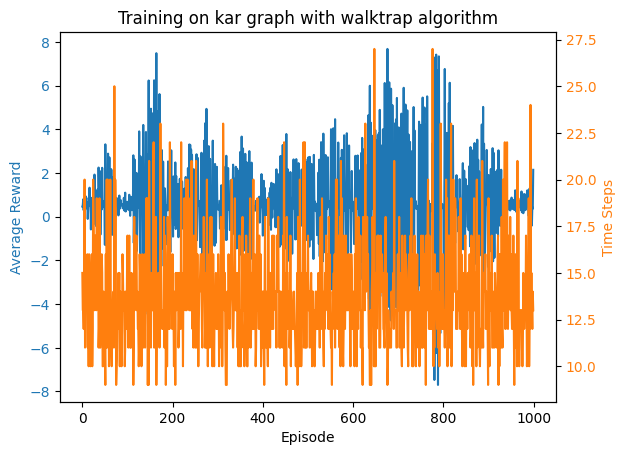

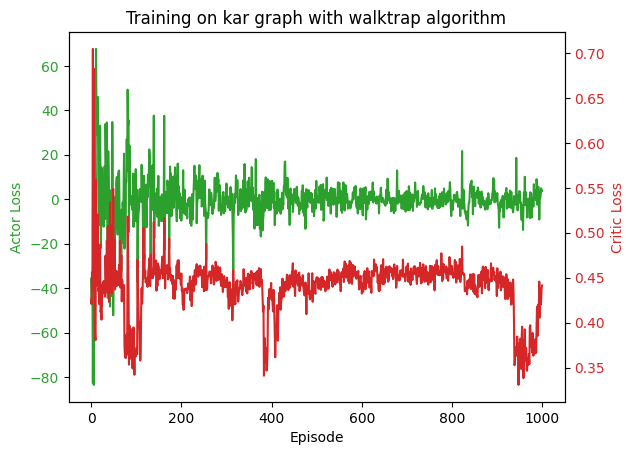

In [21]:
print("*"*20, "Setup Information", "*"*20)

# ° ------ Graph Setup ------ ° #
# ! REAL GRAPH Graph path (change the following line to change the graph)
graph_path = FilePaths.KAR.value
# ! SYNTHETIC GRAPH Graph path (change the following line to change the graph)
# graph, graph_path = Utils.generate_lfr_benchmark_graph()

# Set the environment name as the graph name
env_name = graph_path.split("/")[-1].split(".")[0]
# Load the graph from the dataset folder
graph = Utils.import_mtx_graph(graph_path)
# Print the number of nodes and edges
print("* Graph Name:", env_name)
print("*", graph)

# ° --- Environment Setup --- ° #
# ! Define the detection algorithm to use (change the following line to change the algorithm)
detection_alg = DetectionAlgorithms.WALK.value
print("* Community Detection Algorithm:", detection_alg)
# Apply the community detection algorithm on the graph
dct = DetectionAlgorithm(detection_alg)
community_structure = dct.compute_community(graph)
# Choose one of the communities found by the algorithm, for now we choose
# the community with the highest number of nodes
community_target = max(community_structure, key=len)
print("* Community Target:", community_target)
# TEST: Choose a node to remove from the community
nodes_target = [community_target[0]]
print("* Nodes Target:", nodes_target)

# Define the environment
env = GraphEnvironment(
    graph=graph,
    community=community_target,
    nodes_target=nodes_target,
    beta=HyperParams.BETA.value, # % of actions to perform
    weight=HyperParams.WEIGHT.value, # weight to balance the reward
    debug=False,
    training=True,
    env_name=env_name,
    community_detection_algorithm=detection_alg)
# Get list of possible actions which can be performed on the graph by the agent
n_actions = len(env.possible_actions["ADD"]) + \
    len(env.possible_actions["REMOVE"])
print("* Number of possible actions:", n_actions)

# ° ------ Agent Setup ------ ° #
# Define the agent
agent = Agent(
    state_dim=HyperParams.G_IN_SIZE.value,      # Dimensions of the state
    action_dim=graph.number_of_nodes(),         # Number of possible actions
    action_std=HyperParams.ACTION_STD.value,    # Standard deviation for the action
    lr=HyperParams.LR.value,                    # Learning rate
    gamma=HyperParams.GAMMA.value,              # Gamma parameter
    eps=HyperParams.EPS_CLIP.value,)            # Value for clipping the loss function
# Define Memory
# memory = Memory()
print("*", "-"*53)
print("*"*20, "End Information", "*"*20, "\n")

log = agent.training(env, env_name, detection_alg)
file_path = FilePaths.TEST_DIR.value + env_name + '/' + detection_alg
Utils.check_dir(file_path)
Utils.save_training(log, env_name, detection_alg, file_path=file_path)
Utils.plot_training(log, env_name, detection_alg, file_path=file_path)
